<a href="https://colab.research.google.com/github/AndreRab/Ensamble-generation/blob/main/Experiment1_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependecies

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.nn as nn

import matplotlib.pyplot as plt

import random

from tqdm import tqdm

from sklearn.metrics import accuracy_score
from torchmetrics.classification import MulticlassCalibrationError
import torch.nn.functional as F

import warnings
from typing import Iterable, Union, Tuple, Callable, Dict
import logging

from torch.nn.utils import parameters_to_vector, vector_to_parameters


## Hyper-parameters

In [3]:
batch_szie = 16
MNIST_size = 28

lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Dataset preporation

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.38MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.68MB/s]


In [5]:
train_loader = DataLoader(train_dataset, batch_size=batch_szie, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_szie, shuffle=False)

In [6]:
def show_sample(dataset):
  index = random.randint(0, len(dataset) - 1)
  plt.imshow(dataset.data[index], cmap='gray')

def get_sample(dataset):
  index = random.randint(0, len(dataset) - 1)
  return dataset.data[index].view(1, -1).float()

get_sample(train_dataset).size()

torch.Size([1, 784])

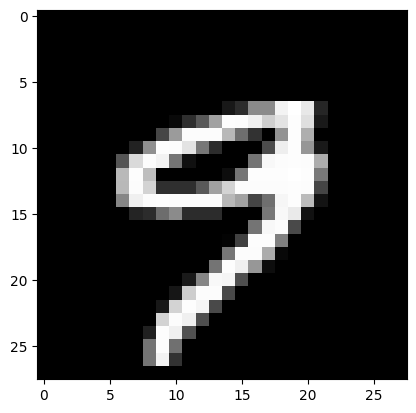

In [7]:
show_sample(train_dataset)

## Models

### Model's weights update functions

In [8]:
import torch
import logging
from typing import Dict

StateDict = Dict[str, torch.Tensor]

def _are_shapes_compatible(shape1, shape2):
    reversed_shape1 = reversed(shape1)
    reversed_shape2 = reversed(shape2)
    for dim1, dim2 in zip(reversed_shape1, reversed_shape2):
        if dim1 != dim2:
            return False
    return True

def _smart_reshape(tensor, desired_shape):
    tensor_num_elements = tensor.numel()
    desired_num_elements = torch.prod(torch.tensor(desired_shape)).item()
    if _are_shapes_compatible(tensor.shape, desired_shape):
        return tensor
    elif tensor_num_elements == desired_num_elements:
        return tensor.reshape(desired_shape)
    elif tensor_num_elements > desired_num_elements:
        extra_dim = tensor_num_elements // desired_num_elements
        new_shape = (extra_dim,) + desired_shape
        return tensor.reshape(new_shape)
    else:
        raise ValueError("The tensor has fewer elements than the desired shape.")

def load_partial_state_dict(
    module,
    state_dict: StateDict,
    prev_state_dict: StateDict = {},
    strict_shapes: bool = True,
):
    params_dict = dict(module.named_parameters())

    for param_path, new_value in state_dict.items():
        if param_path not in params_dict:
            logging.warning(f"[load_partial_state_dict] Parameter {param_path} not found in module.")
            continue

        current_param = params_dict[param_path]
        shape, new_shape = current_param.shape, new_value.shape

        assert (strict_shapes and new_shape == shape) or (
            not strict_shapes and (
                new_shape.numel() == shape.numel()
                or _are_shapes_compatible(new_shape, shape)
            )
        ), f"param_path={param_path} shape={new_shape} current shape={shape}"

        prev_state_dict[param_path] = current_param

        module_path, param_name = param_path.rsplit(".", 1) if "." in param_path else ("", param_path)
        parent_module = module
        if module_path:
            for name in module_path.split("."):
                parent_module = parent_module._modules[name]

        parent_module._parameters[param_name] = (
            new_value if new_shape == shape else _smart_reshape(new_value, shape)
        )

    return module

def load_state_dict(
    module,
    state_dict: StateDict,
    path="",
    prev_state_dict: StateDict = {},
    strict_shapes: bool = True,
):
    if len(state_dict) < 0.25 * len(list(module.parameters())):
        return load_partial_state_dict(
            module,
            state_dict,
            prev_state_dict=prev_state_dict,
            strict_shapes=strict_shapes,
        )

    for name, m in module._modules.items():
        load_state_dict(
            m,
            state_dict,
            path=f"{path}.{name}",
            prev_state_dict=prev_state_dict,
            strict_shapes=strict_shapes,
        )

    for name in module._parameters.keys():
        sample_path = f"{path}.{name}"[1:]  # remove leading dot

        if sample_path not in state_dict:
            continue
        new_value = state_dict[sample_path]
        shape, new_shape = module._parameters[name].shape, new_value.shape

        assert (strict_shapes and new_shape == shape) or (
            not strict_shapes and (
                new_shape.numel() == shape.numel()
                or _are_shapes_compatible(new_shape, shape)
            )
        ), f"sample_path={sample_path} shape={new_shape} current shape={shape}"

        prev_state_dict[sample_path] = module._parameters[name]
        module._parameters[name] = (
            new_value if new_shape == shape else _smart_reshape(new_value, shape)
        )

    return module

def vector_to_named_state_dict(model, vector):
    state_dict = {}
    offset = 0
    for name, param in model.named_parameters():
        numel = param.numel()
        shape = param.shape
        chunk = vector[0, offset:offset + numel].view(shape)
        state_dict[name] = chunk
        offset += numel
    return state_dict

### Base model

In [9]:
class OneLayerModel(nn.Module):
    def __init__(self, input_dim, classes_num, dropout_rate=0.5) -> None:
        self.input_dim = input_dim
        self.classes_num = classes_num
        super(OneLayerModel, self).__init__()
        self.linear = nn.Linear(input_dim, classes_num, bias=False)
        self.dropout = nn.Dropout(p=dropout_rate) if dropout_rate else None

    def forward(self, x):
        x = x.view(x.size(0), -1)
        if self.dropout:
          x = self.dropout(x)
        return self.linear(x)


In [10]:
base_model = OneLayerModel(MNIST_size * MNIST_size, 10)

In [11]:
def train_classic(model, train_loader, test_loader, num_epochs=10, lr=1e-3, device='cpu'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_accuracies = []
    test_accuracies = []
    train_losses = []
    eval_losses = []
    ece_scores = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)
        train_accuracies.append(train_acc)
        train_losses.append(avg_loss)

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        eval_loss_total = 0
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                probs = F.softmax(outputs, dim=1)
                preds = probs.argmax(dim=1)

                eval_loss_total += loss.item()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_preds.extend(preds.cpu())
                all_labels.extend(labels.cpu())
                all_probs.append(probs.cpu())

        eval_loss = eval_loss_total / len(test_loader)
        test_acc = correct / total
        all_probs_tensor = torch.cat(all_probs)
        all_labels_tensor = torch.tensor(all_labels)

        ece = MulticlassCalibrationError(num_classes=all_probs_tensor.shape[1], n_bins=15)
        ece_score = ece(all_probs_tensor, all_labels_tensor).item()

        eval_losses.append(eval_loss)
        test_accuracies.append(test_acc)
        ece_scores.append(ece_score)

        print(f"Epoch {epoch}: "
              f"Train Loss={avg_loss:.4f}, Train Acc={train_acc:.4f} | "
              f"Eval Loss={eval_loss:.4f}, Eval Acc={test_acc:.4f}, ECE={ece_score:.4f}")

    result = {
        'train_losses': train_losses,
        'eval_losses': eval_losses,
        'train_accuracies': train_accuracies,
        'eval_accuracies': test_accuracies,
        'ece': ece_scores
    }

    return result

In [12]:
base_model_train_history = train_classic(base_model, train_loader, test_loader, device=device, num_epochs=20)

Epoch 1: 100%|██████████| 3750/3750 [00:19<00:00, 196.47it/s]


Epoch 1: Train Loss=0.5461, Train Acc=0.8465 | Eval Loss=0.3233, Eval Acc=0.9117, ECE=0.0487


Epoch 2: 100%|██████████| 3750/3750 [00:11<00:00, 336.58it/s]


Epoch 2: Train Loss=0.4372, Train Acc=0.8696 | Eval Loss=0.3050, Eval Acc=0.9154, ECE=0.0339


Epoch 3: 100%|██████████| 3750/3750 [00:11<00:00, 336.38it/s]


Epoch 3: Train Loss=0.4288, Train Acc=0.8735 | Eval Loss=0.3046, Eval Acc=0.9180, ECE=0.0334


Epoch 4: 100%|██████████| 3750/3750 [00:11<00:00, 336.68it/s]


Epoch 4: Train Loss=0.4274, Train Acc=0.8743 | Eval Loss=0.3029, Eval Acc=0.9176, ECE=0.0285


Epoch 5: 100%|██████████| 3750/3750 [00:11<00:00, 325.35it/s]


Epoch 5: Train Loss=0.4241, Train Acc=0.8767 | Eval Loss=0.3034, Eval Acc=0.9170, ECE=0.0249


Epoch 6: 100%|██████████| 3750/3750 [00:11<00:00, 335.21it/s]


Epoch 6: Train Loss=0.4221, Train Acc=0.8761 | Eval Loss=0.2991, Eval Acc=0.9182, ECE=0.0247


Epoch 7: 100%|██████████| 3750/3750 [00:11<00:00, 337.65it/s]


Epoch 7: Train Loss=0.4216, Train Acc=0.8778 | Eval Loss=0.2996, Eval Acc=0.9162, ECE=0.0202


Epoch 8: 100%|██████████| 3750/3750 [00:11<00:00, 339.13it/s]


Epoch 8: Train Loss=0.4209, Train Acc=0.8761 | Eval Loss=0.2992, Eval Acc=0.9160, ECE=0.0223


Epoch 9: 100%|██████████| 3750/3750 [00:11<00:00, 334.47it/s]


Epoch 9: Train Loss=0.4230, Train Acc=0.8762 | Eval Loss=0.2988, Eval Acc=0.9194, ECE=0.0247


Epoch 10: 100%|██████████| 3750/3750 [00:10<00:00, 342.77it/s]


Epoch 10: Train Loss=0.4179, Train Acc=0.8790 | Eval Loss=0.3017, Eval Acc=0.9166, ECE=0.0234


Epoch 11: 100%|██████████| 3750/3750 [00:10<00:00, 342.63it/s]


Epoch 11: Train Loss=0.4238, Train Acc=0.8767 | Eval Loss=0.3008, Eval Acc=0.9178, ECE=0.0240


Epoch 12: 100%|██████████| 3750/3750 [00:11<00:00, 338.14it/s]


Epoch 12: Train Loss=0.4216, Train Acc=0.8781 | Eval Loss=0.3024, Eval Acc=0.9176, ECE=0.0225


Epoch 13: 100%|██████████| 3750/3750 [00:11<00:00, 318.64it/s]


Epoch 13: Train Loss=0.4208, Train Acc=0.8768 | Eval Loss=0.2996, Eval Acc=0.9179, ECE=0.0234


Epoch 14: 100%|██████████| 3750/3750 [00:11<00:00, 332.79it/s]


Epoch 14: Train Loss=0.4197, Train Acc=0.8771 | Eval Loss=0.3036, Eval Acc=0.9177, ECE=0.0205


Epoch 15: 100%|██████████| 3750/3750 [00:11<00:00, 334.43it/s]


Epoch 15: Train Loss=0.4219, Train Acc=0.8772 | Eval Loss=0.3007, Eval Acc=0.9175, ECE=0.0215


Epoch 16: 100%|██████████| 3750/3750 [00:11<00:00, 336.74it/s]


Epoch 16: Train Loss=0.4226, Train Acc=0.8776 | Eval Loss=0.3003, Eval Acc=0.9178, ECE=0.0207


Epoch 17: 100%|██████████| 3750/3750 [00:11<00:00, 336.04it/s]


Epoch 17: Train Loss=0.4215, Train Acc=0.8773 | Eval Loss=0.2994, Eval Acc=0.9203, ECE=0.0255


Epoch 18: 100%|██████████| 3750/3750 [00:11<00:00, 334.68it/s]


Epoch 18: Train Loss=0.4192, Train Acc=0.8778 | Eval Loss=0.2994, Eval Acc=0.9199, ECE=0.0237


Epoch 19: 100%|██████████| 3750/3750 [00:11<00:00, 333.67it/s]


Epoch 19: Train Loss=0.4209, Train Acc=0.8780 | Eval Loss=0.3020, Eval Acc=0.9189, ECE=0.0211


Epoch 20: 100%|██████████| 3750/3750 [00:11<00:00, 333.72it/s]


Epoch 20: Train Loss=0.4192, Train Acc=0.8802 | Eval Loss=0.3046, Eval Acc=0.9173, ECE=0.0208


### Meta model

In [13]:
class MetaModelWithTwoLayers(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim=None):
    if not output_dim:
      output_dim = input_dim
    super(MetaModelWithTwoLayers, self).__init__()
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = nn.Linear(hidden_dim, output_dim)
    self.activation_fn = nn.ReLU()

  def forward(self, x):
    output = self.activation_fn(self.linear1(x))
    output = self.activation_fn(self.linear2(output))
    output = (self.linear3(output))

    return output

In [14]:
base_model_blank = OneLayerModel(MNIST_size * MNIST_size, 10, dropout_rate=None)

ONE_LAYER_MODEL_PARAMETERS_SIZE = sum(p.numel() for p in base_model_blank.parameters() if p.requires_grad)
print(ONE_LAYER_MODEL_PARAMETERS_SIZE)
HIDDEN_LAYER_SIZE = int(ONE_LAYER_MODEL_PARAMETERS_SIZE / 4 * 3)
print(HIDDEN_LAYER_SIZE)

7840
5880


In [57]:
meta_model = MetaModelWithTwoLayers(ONE_LAYER_MODEL_PARAMETERS_SIZE, HIDDEN_LAYER_SIZE)

### Train and evaluate loop

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = meta_model.parameters(), lr=0.0003)

In [59]:
def random_half_mask_generation(size):
    num_ones = size // 2
    num_zeros = size - num_ones
    mask = torch.cat([torch.ones(num_ones), torch.zeros(num_zeros)])
    return mask[torch.randperm(size)]

def generate_noise_vector(size):
    mask = random_half_mask_generation(size)
    return (mask * torch.randn(size)).view(1, -1)

def extract_new_weights(meta_output, meta_input):
    mask = (meta_input == 0)
    return torch.where(mask, meta_output, meta_input)

def train_epoch(meta_model, base_model, criterion, optimizer, train_loader, device):
    loss_by_epoch = []
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        parameters = parameters_to_vector(base_model.parameters()).to(device)
        meta_model_input = generate_noise_vector(parameters.numel()).to(device)
        new_weights = extract_new_weights(meta_model(meta_model_input), meta_model_input).to(device)

        new_weights_dict = vector_to_named_state_dict(base_model, new_weights)
        load_state_dict(base_model, new_weights_dict)

        outputs = base_model(inputs)
        loss = criterion(outputs, labels)
        loss_by_epoch.append(loss.item())

        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

        loss.backward()
        optimizer.step()

    res = {
        'loss': sum(loss_by_epoch) / len(loss_by_epoch),
        'acc': accuracy_score(all_labels, all_preds),
    }
    return res


def generate_new_model(new_weights, input_dim, classes_num):
    model = OneLayerModel(input_dim, classes_num, dropout_rate=None)
    new_weights_dict = vector_to_named_state_dict(model, new_weights)
    load_state_dict(model, new_weights_dict)
    return model


def get_ensemble(meta_model, base_model, device, num_models):
    ensemble = []
    param_size = parameters_to_vector(base_model.parameters()).numel()
    for _ in range(num_models):
        meta_model_input = generate_noise_vector(param_size).to(device)
        new_weights = extract_new_weights(meta_model(meta_model_input), meta_model_input).to(device)
        model = generate_new_model(new_weights, base_model.input_dim, base_model.classes_num).to(device)
        model.eval()
        ensemble.append(model)
    return ensemble


def get_ensemble_results(ensemble, inputs):
    logits = torch.stack([model(inputs) for model in ensemble])

    probs = torch.softmax(logits, dim=2)
    mean_probs = torch.mean(probs, dim=0)
    var_probs = torch.var(probs, dim=0)

    return mean_probs, var_probs, logits.mean(dim=0)

def eval_epoch(meta_model, base_model, criterion, eval_loader, device, number_of_models_in_ensemble=10):
    loss_by_epoch = []
    all_preds = []
    all_labels = []
    all_probs = []
    all_var_probs = []

    ensemble = get_ensemble(meta_model, base_model, device, number_of_models_in_ensemble)

    for batch in tqdm(eval_loader):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            mean_probs, var_probs, logits = get_ensemble_results(ensemble, inputs)
            loss = criterion(logits, labels)

        loss_by_epoch.append(loss.item())
        preds = mean_probs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        all_probs.append(mean_probs.cpu())
        all_var_probs.append(var_probs.cpu())

    all_probs_tensor = torch.cat(all_probs, dim=0)
    all_var_tensor = torch.cat(all_var_probs, dim=0)
    all_labels_tensor = torch.tensor(all_labels)

    ece = MulticlassCalibrationError(num_classes=all_probs_tensor.size(1), n_bins=15)
    ece_score = ece(all_probs_tensor, all_labels_tensor).item()

    res = {
        'loss': sum(loss_by_epoch) / len(loss_by_epoch),
        'acc': accuracy_score(all_labels, all_preds),
        'ece': ece_score,
        'mean_variance': all_var_tensor.mean().item(),
    }

    return res

In [60]:
def train_and_eval(num_epochs, meta_model, base_model, criterion, optimizer, train_loader, eval_loader, device='cpu'):
    meta_model.to(device)
    base_model.to(device)
    base_model.eval()
    train_losses, eval_losses = [], []
    train_accuracies, eval_accuracies = [], []
    eval_var = []
    ece = []

    for epoch in range(1, num_epochs + 1):
        meta_model.train()
        results = train_epoch(meta_model, base_model, criterion, optimizer, train_loader, device)
        train_loss, train_acc, = results['loss'], results['acc']
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        meta_model.eval()
        results = eval_epoch(meta_model, base_model, criterion, eval_loader, device)
        eval_loss, eval_acc, eval_ece, eval_mean_var = results['loss'], results['acc'], results['ece'], results['mean_variance']
        eval_losses.append(eval_loss)
        eval_accuracies.append(eval_acc)
        eval_var.append(eval_mean_var)
        ece.append(eval_ece)

        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Eval Loss={eval_loss:.4f}, Acc={eval_acc:.4f}, Ece={eval_ece:.4f}")

    res = {
        'train_losses': train_losses,
        'eval_losses': eval_losses,
        'train_accuracies': train_accuracies,
        'eval_accuracies' : eval_accuracies,
        'eval_var': eval_var,
        'ece': ece
    }

    return res

def compare_train_results(ensamble_res, base_res=None):
    ensamble_train_losses = ensamble_res['train_losses']
    ensamble_eval_losses = ensamble_res['eval_losses']
    ensamble_train_accuracies = ensamble_res['train_accuracies']
    ensamble_eval_accuracies = ensamble_res['eval_accuracies']
    ensamble_ece = ensamble_res['ece']

    base_train_losses, base_eval_losses = [], []
    base_train_accuracies, base_eval_accuracies = [], []
    base_ece = []

    if base_res:
        base_train_losses = base_res['train_losses']
        base_eval_losses = base_res['eval_losses']
        base_train_accuracies = base_res['train_accuracies']
        base_eval_accuracies = base_res['eval_accuracies']
        base_ece = base_res['ece']

    fig, axs = plt.subplots(2, 3, figsize=(18, 8))

    axs[0, 0].plot(ensamble_train_losses, c='r', label='Train Loss ensamble')
    axs[0, 0].plot(ensamble_eval_losses, c='b', label='Eval Loss ensamble')
    if base_res:
        axs[0, 0].plot(base_eval_losses, c='g', label='Eval Loss base')
    axs[0, 0].set_title("Loss")
    axs[0, 0].legend()

    axs[0, 1].plot(ensamble_train_accuracies, c='r', label='Train Acc ensamble')
    axs[0, 1].plot(ensamble_eval_accuracies, c='b', label='Eval Acc ensamble')
    if base_res:
        axs[0, 1].plot(base_eval_accuracies, c='g', label='Eval Acc base')
    axs[0, 1].set_title("Accuracy")
    axs[0, 1].legend()

    axs[0, 2].plot(ensamble_ece, c='b', label='Eval Ece ensamble')
    if base_res:
        axs[0, 2].plot(base_ece, c='g', label='Eval Ece base')
    axs[0, 2].set_title("ECE")
    axs[0, 2].legend()

    axs[1, 0].plot(ensamble_res['eval_var'], c='b', label='Variance ensamble')
    axs[1, 0].set_title("Variance")
    axs[1, 0].legend()


    fig.delaxes(axs[1, 1])
    fig.delaxes(axs[1, 2])
    plt.tight_layout()
    plt.show()

In [61]:
ensamble_train_history = train_and_eval(20, meta_model, base_model_blank, criterion, optimizer, train_loader, test_loader, device)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 3750/3750 [00:49<00:00, 75.68it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Ten

Epoch 1: Train Loss=4.4032, Acc=0.5095 | Eval Loss=0.8430, Acc=0.8623, Ece=0.1159


100%|██████████| 3750/3750 [00:49<00:00, 75.82it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 417.34it/s]


Epoch 2: Train Loss=2.4538, Acc=0.7333 | Eval Loss=0.8428, Acc=0.8878, Ece=0.0875


100%|██████████| 3750/3750 [00:49<00:00, 75.85it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 404.56it/s]


Epoch 3: Train Loss=2.3000, Acc=0.7615 | Eval Loss=0.7907, Acc=0.8919, Ece=0.0871


100%|██████████| 3750/3750 [00:49<00:00, 75.79it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 346.53it/s]


Epoch 4: Train Loss=2.2163, Acc=0.7730 | Eval Loss=0.8177, Acc=0.8833, Ece=0.0750


100%|██████████| 3750/3750 [00:49<00:00, 75.80it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 313.75it/s]


Epoch 5: Train Loss=2.1958, Acc=0.7782 | Eval Loss=0.8590, Acc=0.8940, Ece=0.0872


100%|██████████| 3750/3750 [00:49<00:00, 75.86it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 402.30it/s]


Epoch 6: Train Loss=2.1421, Acc=0.7837 | Eval Loss=0.8043, Acc=0.9004, Ece=0.0632


100%|██████████| 3750/3750 [00:49<00:00, 75.86it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 413.27it/s]


Epoch 7: Train Loss=2.1153, Acc=0.7871 | Eval Loss=0.8612, Acc=0.8963, Ece=0.0671


100%|██████████| 3750/3750 [00:49<00:00, 75.70it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 414.29it/s]


Epoch 8: Train Loss=2.0841, Acc=0.7893 | Eval Loss=0.8130, Acc=0.8998, Ece=0.0726


100%|██████████| 3750/3750 [00:49<00:00, 75.80it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 331.94it/s]


Epoch 9: Train Loss=2.0999, Acc=0.7912 | Eval Loss=0.8730, Acc=0.8945, Ece=0.0641


100%|██████████| 3750/3750 [00:49<00:00, 75.83it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 411.88it/s]


Epoch 10: Train Loss=2.0629, Acc=0.7918 | Eval Loss=0.8409, Acc=0.9006, Ece=0.0769


100%|██████████| 3750/3750 [00:49<00:00, 75.84it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 334.46it/s]


Epoch 11: Train Loss=2.0535, Acc=0.7933 | Eval Loss=0.8460, Acc=0.9032, Ece=0.0615


100%|██████████| 3750/3750 [00:49<00:00, 75.90it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 368.11it/s]


Epoch 12: Train Loss=2.0657, Acc=0.7956 | Eval Loss=0.8667, Acc=0.8952, Ece=0.0752


100%|██████████| 3750/3750 [00:49<00:00, 75.89it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 412.95it/s]


Epoch 13: Train Loss=2.0406, Acc=0.7974 | Eval Loss=0.8397, Acc=0.8977, Ece=0.0495


100%|██████████| 3750/3750 [00:49<00:00, 75.94it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 408.06it/s]


Epoch 14: Train Loss=2.0008, Acc=0.7972 | Eval Loss=0.8159, Acc=0.8971, Ece=0.0721


100%|██████████| 3750/3750 [00:49<00:00, 75.80it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 413.28it/s]


Epoch 15: Train Loss=2.0161, Acc=0.7969 | Eval Loss=0.8866, Acc=0.8939, Ece=0.0563


100%|██████████| 3750/3750 [00:49<00:00, 75.86it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 345.70it/s]


Epoch 16: Train Loss=2.0209, Acc=0.7961 | Eval Loss=0.7821, Acc=0.9036, Ece=0.0676


100%|██████████| 3750/3750 [00:49<00:00, 75.87it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 414.79it/s]


Epoch 17: Train Loss=2.0231, Acc=0.7985 | Eval Loss=0.8835, Acc=0.8958, Ece=0.0643


100%|██████████| 3750/3750 [00:49<00:00, 75.93it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 419.45it/s]


Epoch 18: Train Loss=2.0117, Acc=0.7971 | Eval Loss=0.8412, Acc=0.9030, Ece=0.0569


100%|██████████| 3750/3750 [00:49<00:00, 75.81it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 404.84it/s]


Epoch 19: Train Loss=1.9940, Acc=0.7982 | Eval Loss=0.8538, Acc=0.9042, Ece=0.0702


100%|██████████| 3750/3750 [00:49<00:00, 75.84it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:02<00:00, 309.30it/s]

Epoch 20: Train Loss=1.9898, Acc=0.7995 | Eval Loss=0.8875, Acc=0.9010, Ece=0.0674


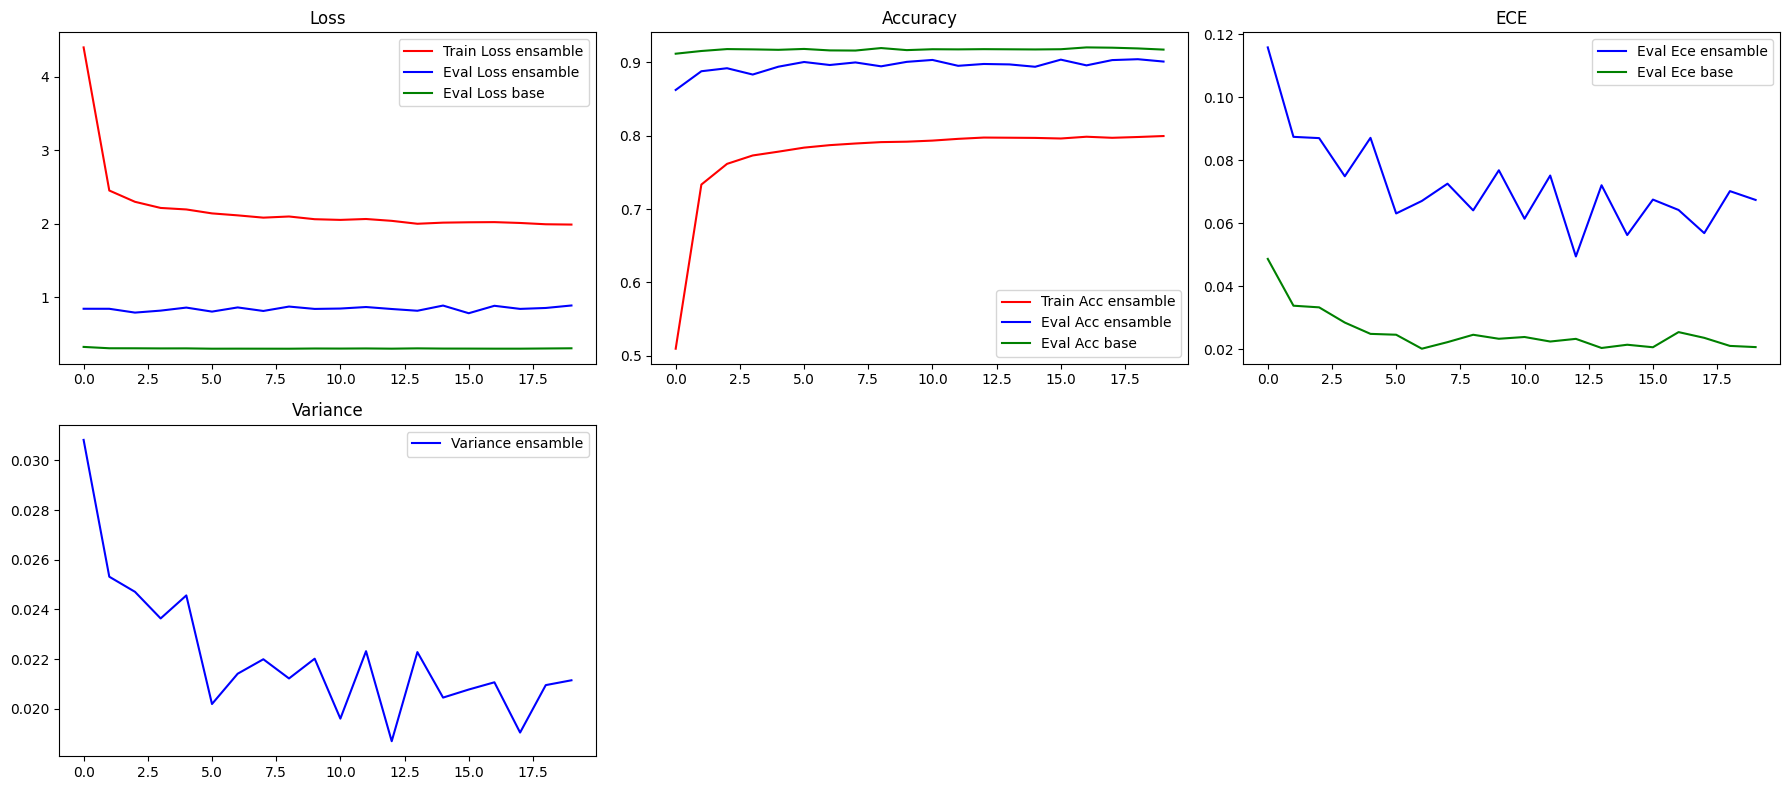

In [62]:
compare_train_results(ensamble_train_history, base_model_train_history)

In [63]:
ensamble_train_history_extra_20 = train_and_eval(20, meta_model, base_model_blank, criterion, optimizer, train_loader, test_loader, device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 3750/3750 [00:50<00:00, 74.69it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Ten

Epoch 1: Train Loss=1.9931, Acc=0.7984 | Eval Loss=0.8311, Acc=0.9016, Ece=0.0639


100%|██████████| 3750/3750 [00:49<00:00, 75.81it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 409.88it/s]


Epoch 2: Train Loss=1.9927, Acc=0.7995 | Eval Loss=0.7968, Acc=0.9083, Ece=0.0786


100%|██████████| 3750/3750 [00:49<00:00, 75.79it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 381.92it/s]


Epoch 3: Train Loss=1.9725, Acc=0.8024 | Eval Loss=0.8002, Acc=0.9086, Ece=0.0726


100%|██████████| 3750/3750 [00:49<00:00, 75.60it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 392.34it/s]


Epoch 4: Train Loss=1.9747, Acc=0.7993 | Eval Loss=0.8099, Acc=0.9033, Ece=0.0588


100%|██████████| 3750/3750 [00:49<00:00, 75.87it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 406.44it/s]


Epoch 5: Train Loss=1.9701, Acc=0.7994 | Eval Loss=0.8096, Acc=0.9046, Ece=0.0653


100%|██████████| 3750/3750 [00:49<00:00, 75.88it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 406.35it/s]


Epoch 6: Train Loss=1.9641, Acc=0.7995 | Eval Loss=0.8204, Acc=0.9012, Ece=0.0519


100%|██████████| 3750/3750 [00:49<00:00, 75.75it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 356.27it/s]


Epoch 7: Train Loss=1.9459, Acc=0.8026 | Eval Loss=0.8298, Acc=0.9015, Ece=0.0665


100%|██████████| 3750/3750 [00:49<00:00, 75.75it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 404.69it/s]


Epoch 8: Train Loss=1.9691, Acc=0.8010 | Eval Loss=0.8395, Acc=0.8961, Ece=0.0546


100%|██████████| 3750/3750 [00:51<00:00, 73.11it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 397.10it/s]


Epoch 9: Train Loss=1.9468, Acc=0.8005 | Eval Loss=0.8273, Acc=0.9061, Ece=0.0572


100%|██████████| 3750/3750 [00:49<00:00, 75.94it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 409.45it/s]


Epoch 10: Train Loss=1.9227, Acc=0.8027 | Eval Loss=0.8373, Acc=0.9083, Ece=0.0563


100%|██████████| 3750/3750 [00:49<00:00, 75.76it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 320.81it/s]


Epoch 11: Train Loss=1.9123, Acc=0.8013 | Eval Loss=0.7764, Acc=0.9077, Ece=0.0724


100%|██████████| 3750/3750 [00:49<00:00, 75.84it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 408.17it/s]


Epoch 12: Train Loss=1.9386, Acc=0.8004 | Eval Loss=0.7943, Acc=0.9030, Ece=0.0565


100%|██████████| 3750/3750 [00:49<00:00, 75.98it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 406.80it/s]


Epoch 13: Train Loss=1.8734, Acc=0.8040 | Eval Loss=0.8135, Acc=0.9020, Ece=0.0756


100%|██████████| 3750/3750 [00:49<00:00, 75.88it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 402.81it/s]


Epoch 14: Train Loss=1.8739, Acc=0.8036 | Eval Loss=0.8696, Acc=0.8989, Ece=0.0566


100%|██████████| 3750/3750 [00:49<00:00, 75.92it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 333.91it/s]


Epoch 15: Train Loss=1.8772, Acc=0.8028 | Eval Loss=0.7833, Acc=0.9024, Ece=0.0758


100%|██████████| 3750/3750 [00:49<00:00, 75.97it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 404.76it/s]


Epoch 16: Train Loss=1.8829, Acc=0.8032 | Eval Loss=0.7945, Acc=0.9063, Ece=0.0759


100%|██████████| 3750/3750 [00:49<00:00, 75.96it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 407.94it/s]


Epoch 17: Train Loss=1.8739, Acc=0.8028 | Eval Loss=0.7937, Acc=0.9056, Ece=0.0705


100%|██████████| 3750/3750 [00:49<00:00, 75.92it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 404.99it/s]


Epoch 18: Train Loss=1.8120, Acc=0.8071 | Eval Loss=0.8203, Acc=0.8992, Ece=0.0722


100%|██████████| 3750/3750 [00:49<00:00, 76.02it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 344.21it/s]


Epoch 19: Train Loss=1.8179, Acc=0.8050 | Eval Loss=0.7982, Acc=0.9056, Ece=0.0581


100%|██████████| 3750/3750 [00:49<00:00, 76.05it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 404.28it/s]

Epoch 20: Train Loss=1.8497, Acc=0.8041 | Eval Loss=0.7462, Acc=0.9080, Ece=0.0812


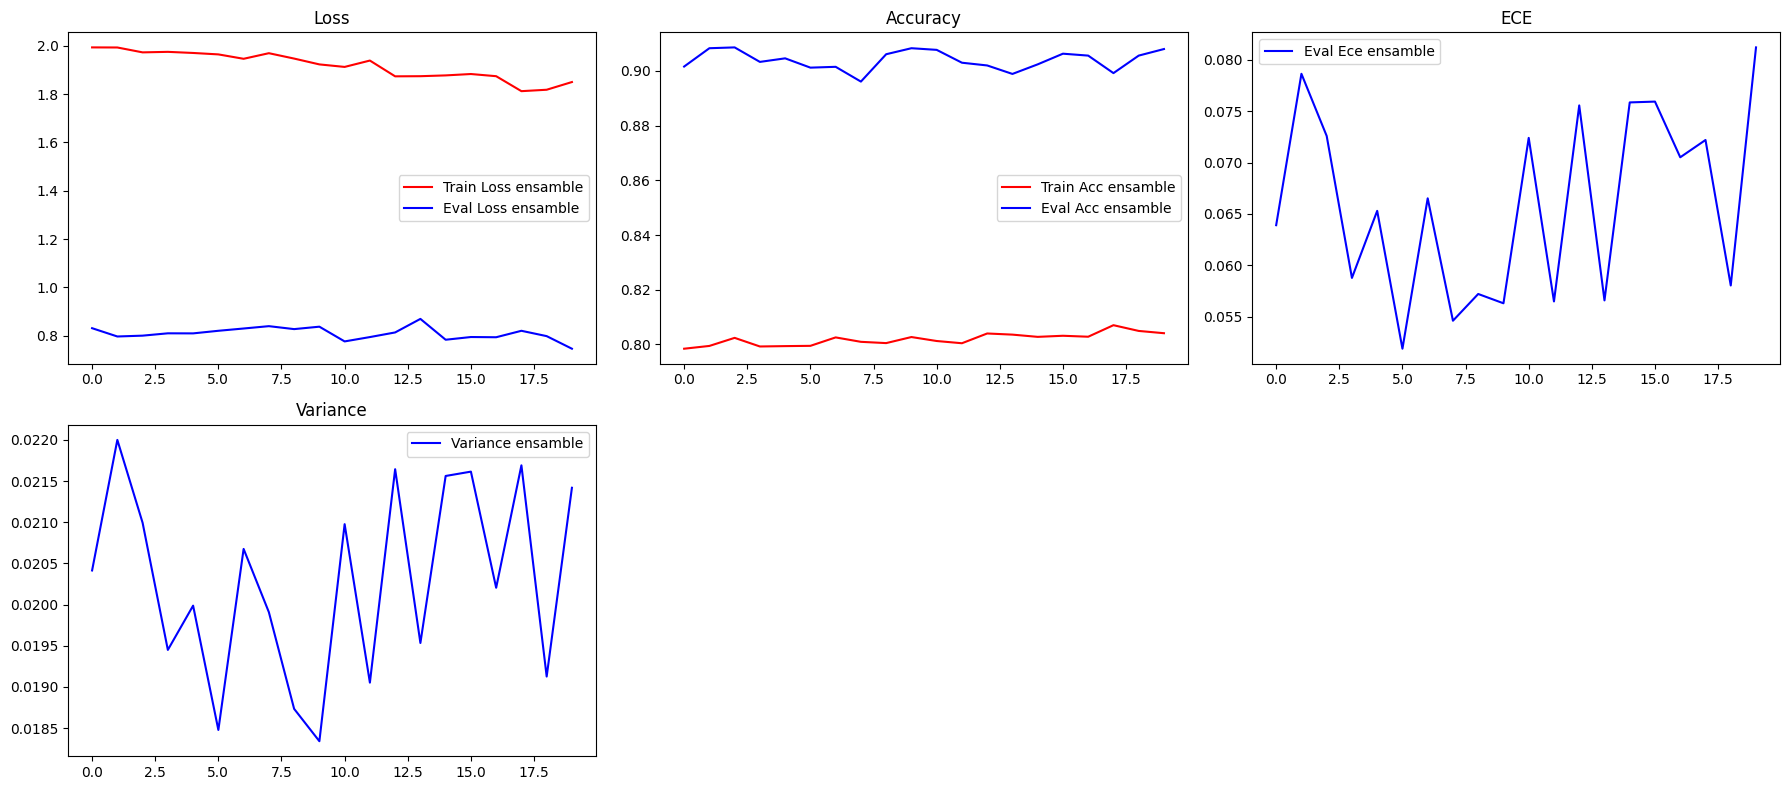

In [64]:
compare_train_results(ensamble_train_history_extra_20)